In [203]:
#Import libraries:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier as gbm #GBM algorithm
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt
from sklearn.metrics import accuracy_score as acc
import dill as pickle

In [204]:
# Define a pipeline class that does the data cleaning, model training, prediction & evaluation for us.
'''
export class definition as classdef.py
'''
class Pipeline:
    
    # data cleaning and define target to train the model on
    def cleaning(self, a):
        target=a['churn'].astype(int)
        a.drop(['churn', 'phone number', 'account length'], axis=1,inplace=True)
        clist=['state', 'international plan', 'voice mail plan']
        for c in clist:
            a[c]=a[c].astype('category').cat.codes
        return a, target
    
    # training the gbm model
    def train(self, a, b):
        self.model=gbm().fit(a, b)
    
    # predicting from gbm model
    def predict(self, a):
        y_hat=self.model.predict(a)
        return y_hat
    
    # calculate churn risk score
    def probs(self, a):
        probs=self.model.predict_proba(a)
        return probs
    
    # calculate feature importance
    def importance(self,a):
        self.feat_imp = pd.Series(self.model.feature_importances_).sort_values(ascending=True)
    
    # calculate model accuracy
    def accuracy(self, a, b):
        self.acc=acc(a,b)
        print('The GBM model accuracy is ' + str(100*self.acc) + ' %.')

In [291]:
# Loading Telco data from local .csv file
df=pd.read_csv('telco_data.csv', low_memory=False)
# Initialize our previously defined pipeline class
pipe=Pipeline()
# Clean our data
df, target=pipe.cleaning(df)   
# Make a train - test split to evaluate the quality of our model on left-out data
X_train, X_test, y_train, y_test = train_test_split(df, target , test_size=0.1, random_state=123)
# Train the model on the training set
pipe.train(X_train, y_train)
# Predict churn on the test set
y_hat = pipe.predict(X_test)
# Calculate corresponding churn probability
probs = pipe.probs(X_test)
# Calculate node accuracy
pipe.accuracy(y_test, y_hat)

The GBM model accuracy is 96.7065868263 %.


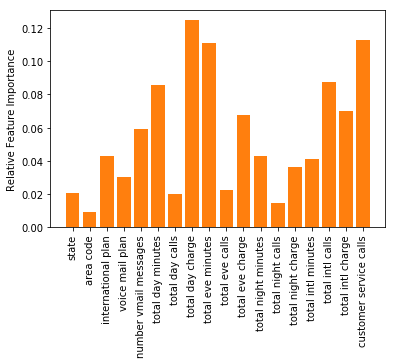

In [140]:
# Visualize feature importance
pipe.importance(df)
names=df.columns
ticks=names[pipe.feat_imp.index]
plt.bar(pipe.feat_imp.index,pipe.feat_imp) 
plt.ylabel('Relative Feature Importance')
plt.xticks(pipe.feat_imp.index, ticks, rotation='vertical')
plt.show()

In [292]:
# Serialize the pipeline object for production
filename = 'churn_model.pk'
with open('./'+filename, 'wb') as file:
	pickle.dump(pipe, file)
# Test whether serialization has worked out
with open('./'+filename ,'rb') as f:
    loaded_pipe = pickle.load(f)
loaded_pipe

In [302]:
# Import relevant libraries for json request
import json
import requests

# Read initial data for having samples to test API deployment
df = pd.read_csv('telco_data.csv')
# All data cleaning is down by our pipeline inside the API, so we only have to send over raw data 
#    -- how convenient!

# Set example data
#lo - idx 0
#hi - idx 15
sub=pd.DataFrame(df[df.index==15])

# Convert data frame to json
djson = sub.to_json()
# Set header for json send/receive
header = {'Content-Type': 'application/json', 'Accept': 'application/json'}
# Request churn risk at our API endpoint:
resp = requests.post("http://0.0.0.0:4000/predict", json = djson, headers= header)
# Print response
resp.json()

'High churn risk.'